## Prefix tuning

В этом ноутбуке мы обучаем префиксы по следующей схеме: 
<br>
Префикс - англицизм - префикс - предложение с англицизмом - префикс - перефраз
<br><br>
Минус этого подхода заключается в том, что на вход модели вместе с предложением нужно подавать англицизм, но, если у нас получится обучить дополнительную модель детектирующую англицизм в предложении, то эта проблема будет решена
<br><br>
Большой плюс этого подхода заключается в том, что модель обучается гораздо лучше и итоговый результат перефраза получается лучше

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.auto import tqdm, trange
import random
import os
import re
import itertools
from collections.abc import Iterable
from transformers import GPT2LMHeadModel,GPT2Tokenizer, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from itertools import product, zip_longest
import loralib as lora
from datasets import load_dataset

/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` i

In [2]:
# device
device='cuda' if torch.cuda.is_available() else 'cpu'
# paths
model_path = 'ai-forever/rugpt3large_based_on_gpt2'
dataset_path = 'shershen/ru_anglicism'
out_dir = 'weights'
# training params
lr = 1e-2
epochs = 5
batch_size = 8
# lengths of prefixes
l1 = 15
l2 = 15
l3 = 40

In [3]:
gpt_model=GPT2LMHeadModel.from_pretrained(model_path,output_hidden_states=True).to(device)
gpt_tokenizer=GPT2Tokenizer.from_pretrained(model_path)

In [4]:
gpt_tokenizer.pad_token='<pad>'

### Предобработка данных: 

Добавляем знак табуляции (\t) в конец предложения и перефраза для того, чтобы модель запомнила как и где останавливаться: при генерации можно будет просто выкидывать всё, что следует за этим знаком

In [5]:
df = load_dataset(dataset_path)
train_df = pd.DataFrame(df['train'])
test_df = pd.DataFrame(df['test'])

No config specified, defaulting to: ru_anglicism/default
Found cached dataset ru_anglicism (/home/jovyan/.cache/huggingface/datasets/shershen___ru_anglicism/default/0.2.0/a1f71309ff0601f2a20ae30cd23f0b52822711d1af481586e36f525a21ed3bc2)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
train_df['sentence'] = train_df['sentence']
train_df['paraphrase'] = train_df['paraphrase'] + '\t'
test_df['sentence'] = test_df['sentence']
test_df['paraphrase'] = test_df['paraphrase'] + '\t'

In [7]:
train_df.head()

,word,form,sentence,paraphrase
0,кринж,кринжовую,Моя подруга рассказала кринжовую историю.,Моя подруга рассказала стыдную историю.\t
1,кринж,кринж,Я словил кринж после этого ролика.,Я испытал стыд после этого ролика.\t
2,кринж,кринж,Ситуация полный кринж.,Ситуация полный стыд.\t
3,"лук, маркетинг","лук, маркетинга",Эта девушка предложила снять новый лук с новой...,Эта девушка предложила снять новый образ с нов...
4,лукбук,лукбуке,"""Розница предусмотрена для тех, у кого нет вре...","""Розница предусмотрена для тех, у кого нет вре..."


In [8]:
test_df.head()

,word,form,sentence,paraphrase
0,скринить,скринит,Эта дура скринит переписки и постит в инстаграм.,Эта дура фотографирует переписки и выставляет ...
1,вайб,вайб,"Не могу это объяснить, но у четверга и 16:00 о...","Не могу это объяснить, но у четверга и 16:00 о..."
2,вайб,вайб,"""Вчера выпал пушистый снег и в воздухе царил н...","""Вчера выпал пушистый снег и в воздухе царило ..."
3,чек-ап,чекап,Программа чекап в ИНВИТРО создана специально д...,Программа комплексного медицинского обследован...
4,чек-ап,Чек-Ап,"В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ...","В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ..."


Функция для создания префикса, инициализируем его не случайно, а берём рандомный вектор с первого слоя модели, в статье авторы писали, что так получается лучше

In [9]:
def create_tensor(tensor_len=30,hid_dim=1024):
    inds = random.sample(range(0, gpt_tokenizer.vocab_size), tensor_len)
    tens = gpt_model.transformer.wte.weight[inds, :].unsqueeze(dim=0).clone().detach()
    return tens

### Training

Циклы для обучения. Для удобства цикл идёт по колонкам и между текстами в колонках пихает заданные тензоры

In [10]:
def train_cycle(model,tokenizer,arr_of_tensors,train_df, optimizer, scheduler=None,dx=8):
    losses=[]
    loss_func=nn.CrossEntropyLoss()
    for pos in tqdm(range(0,len(train_df),dx)):
        optimizer.zero_grad()
        inp_embed=[]
        attention_mask=[]
        current_pos=0
        target_position=[]
        target_tokens=[]
        for tensor,column in zip(arr_of_tensors,train_df.columns):            
            texts=list(train_df[column].values[pos:pos+dx])
            shape_dim_0=len(texts)
            text_tokens=tokenizer(texts,padding=True,return_tensors='pt').to(device)
            text_embedding=model.get_input_embeddings()(text_tokens['input_ids'])
            
            inp_embed.append(tensor.repeat_interleave(shape_dim_0,dim=0))
            attention_mask.append(torch.ones(shape_dim_0,tensor.shape[1]).to(device))
            
            inp_embed.append(text_embedding)
            attention_mask.append(text_tokens['attention_mask'])
            
            if column.find('paraphrase')>=0:
                target_position.extend(range(current_pos+tensor.shape[1]-1,
                                             current_pos+tensor.shape[1]+text_embedding.shape[1]-1))
                mid_target_toks=torch.where(text_tokens['attention_mask']==0,-100,text_tokens['input_ids'])
                target_tokens.append(mid_target_toks)
            current_pos+=tensor.shape[1]+text_embedding.shape[1]
        inp_embed=torch.cat(inp_embed,dim=1)
        attention_mask=torch.cat(attention_mask,dim=1)
        target_tokens=torch.cat(target_tokens,dim=1)
        
        model_output=model(inputs_embeds=inp_embed,attention_mask=attention_mask)['logits'][:,target_position,:]
        loss=loss_func(model_output.view(-1,model_output.size(-1)), target_tokens.view(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        torch.cuda.empty_cache()
    return losses

In [11]:
def val_cycle(model,tokenizer,arr_of_tensors,df,dx=20):
    losses=[]
    loss_func=nn.CrossEntropyLoss()
    for pos in tqdm(range(0,len(df),dx)):
        inp_embed=[]
        attention_mask=[]
        current_pos=0
        target_position=[]
        target_tokens=[]
        for tensor,column in zip(arr_of_tensors,df.columns):
            
            texts=list(df[column].values[pos:pos+dx])
            shape_dim_0=len(texts)
            text_tokens=tokenizer(texts,padding=True,return_tensors='pt').to(device)
            text_embedding=model.get_input_embeddings()(text_tokens['input_ids'])
            
            inp_embed.append(tensor.repeat_interleave(shape_dim_0,dim=0))
            attention_mask.append(torch.ones(shape_dim_0,tensor.shape[1]).to(device))
            
            inp_embed.append(text_embedding)
            attention_mask.append(text_tokens['attention_mask'])
            
            if column.find('paraphrase')>=0:
                target_position.extend(range(current_pos+tensor.shape[1]-1,
                                             current_pos+tensor.shape[1]+text_embedding.shape[1]-1))
                mid_target_toks=torch.where(text_tokens['attention_mask']==0,-100,text_tokens['input_ids'])
                target_tokens.append(mid_target_toks)
            current_pos+=tensor.shape[1]+text_embedding.shape[1]
        inp_embed=torch.cat(inp_embed,dim=1)
        attention_mask=torch.cat(attention_mask,dim=1)
        target_tokens=torch.cat(target_tokens,dim=1)
        
        model_output=model(inputs_embeds=inp_embed,attention_mask=attention_mask)['logits'][:,target_position,:]
        loss=loss_func(model_output.view(-1,model_output.size(-1)), target_tokens.view(-1))
        losses.append(loss.item())
    return losses

In [12]:
angl_arr=[create_tensor(l1).to(device),
          create_tensor(l2).to(device),
          create_tensor(l3).to(device)]
for i in angl_arr:
    i.requires_grad=True

In [13]:
total_steps = (len(train_df) // batch_size) * epochs

In [14]:
optimizer=AdamW([
    {'params':angl_arr, 'lr':lr}
])
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=1e2,
                                           num_training_steps=total_steps)

In [15]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
train_losses = []
val_losses = []
early_stopper = EarlyStopper(patience=1)
for ep in range(epochs):
    train_df=train_df[['form', 'sentence', 'paraphrase']].sample(frac=1)
    l1=train_cycle(gpt_model,
                   gpt_tokenizer,
                   angl_arr,
                   train_df,
                   optimizer,
                   scheduler,
                   dx=batch_size)
    torch.cuda.empty_cache()
    test_df = test_df[['form', 'sentence', 'paraphrase']].sample(frac=1)
    with torch.no_grad():
        l2=val_cycle(gpt_model,
                     gpt_tokenizer,
                     angl_arr,
                     test_df,
                     dx=batch_size)
    print(ep+1,'train',round(np.mean(l1),4),'test',round(np.mean(l2),4))
    train_losses.append(np.mean(l1))
    val_losses.append(np.mean(l2))
    if early_stopper.early_stop(np.mean(l2)):             
        break

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1 train 0.9081 test 0.7211


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2 train 0.5826 test 0.6703


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3 train 0.5233 test 0.6597


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4 train 0.5162 test 0.6592


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5 train 0.4855 test 0.6491


### Рисунок лосса

In [17]:
def draw_result(lst_iter, train_loss, val_loss, title):
    plt.plot(train_loss, '-b', label='train loss')
    plt.plot(val_loss, '-r', label='val loss')

    plt.xlabel('n epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')
    plt.title(title)

    plt.show()

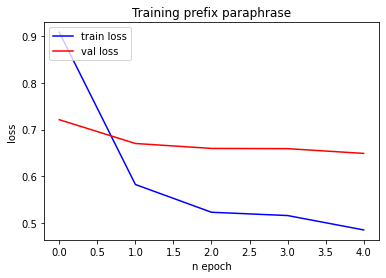

In [18]:
draw_result(epochs, train_losses, val_losses, 'Training prefix paraphrase')

### Сохраняем префиксы

In [35]:
torch.save(angl_arr, os.path.join(out_dir, 'pref_with_word.pt'))

Генерация с использованием префиксов будет показана в другом ноутбуке